# Segmenting and Clustering Neighborhoods in Toronto

In [408]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

In [349]:
# import libraries
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize
import folium 

## Submission 1 
1. Scrape the data from Wikipedia page : 
[*List of postal codes of Canada: M*](https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M)<br> 
2. Transform it to DataFrame<br>
3. Clean the DataFrame

In [350]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

html = urlopen('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
bs = BeautifulSoup(html, 'html.parser')

rows = []
new_rows = []

# get each row(tr) without title row then make a list without html tags
for row in bs.find('table', {'class':'wikitable sortable'}).tr.next_siblings:
    for cell in row:
        rows.append(str(cell).strip('</td>'))

# remove \n
for r in rows:
    if r == '\n':
        continue
    else:
        new_rows.append(r.strip('\n'))

# convert list to np array to reshape
new_rows = np.array(new_rows)
new_rows = new_rows.reshape(180,3)

df = pd.DataFrame(new_rows, columns = ['PostalCode', 'Borough', 'Neighborhood'])
df.head(20)

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


In [351]:
# Table has 180 rows and 3 columns
df.shape

(180, 3)

In [352]:
# extracts the rows with Borough assigned to PostalCode
df = df[df['Borough'] != 'Not assigned']
df.head(20)

,PostalCode,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"
11,M3B,North York,Don Mills
12,M4B,East York,"Parkview Hill, Woodbine Gardens"
13,M5B,Downtown Toronto,"Garden District, Ryerson"


In [353]:
# Check if there are any rows without Neighborhood assigned >> nil
no_neighborhood = df[df['Neighborhood']=='Not assigned']
no_neighborhood.shape

(0, 3)

In [354]:
# Check if there are any duplicate postal code >> nil
duplicate_postal = df[df['PostalCode'].duplicated()]
duplicate_postal.shape

(0, 3)

In [355]:
# Now we have 103 rows with 3 columns
df.shape

(103, 3)

## Submission 2
1. Get the latitude and longitude cordinations of each neighborhood (used csv file)
2. Create the DataFrame together with location data
3. Clean the data (for analisys, we need to have unique neighborhood data, so for the same neighborhood rows being asigned to different postal <br>
 code, I took mean value of location data between them and dropped duplicates.)

In [356]:
# download the geospatial data
import wget
filename = wget.download('http://cocl.us/Geospatial_data')

In [357]:
# convert csv file to pd.DataFrame
# csv file has location data for each postal code
geocode = pd.read_csv('Geospatial_Coordinates.csv')
geocode

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [358]:
# Merge location data to Neighborhood data
df_merged = df.merge(geocode, left_on='PostalCode', right_on='Postal Code', how='left')
df_merged

,PostalCode,Borough,Neighborhood,Postal Code,Latitude,Longitude
0,M3A,North York,Parkwoods,M3A,43.753259,-79.329656
1,M4A,North York,Victoria Village,M4A,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A,43.662301,-79.389494
...,...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",M8X,43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,M4Y,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",M7Y,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",M8Y,43.636258,-79.498509


In [359]:
# drop the one postal code column
df_merged = df_merged.drop('Postal Code',axis=1)

In [360]:
df_merged.head(20)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [361]:
df_merged.shape

(103, 5)

In [362]:
# Check if there are any rows having same neighborhood names in the same Borough
df_merged[df_merged['Neighborhood'].duplicated()]

,PostalCode,Borough,Neighborhood,Latitude,Longitude
13,M3C,North York,Don Mills,43.725900,-79.340923
46,M3L,North York,Downsview,43.739015,-79.506944
53,M3M,North York,Downsview,43.728496,-79.495697
60,M3N,North York,Downsview,43.761631,-79.520999


In [363]:
# Don Mills neighborhood has duplicate
# its inside the same neighborhood but its assigned to different PostalCode
don_mills = df_merged[df_merged['Neighborhood']=='Don Mills']
don_mills

,PostalCode,Borough,Neighborhood,Latitude,Longitude
7,M3B,North York,Don Mills,43.745906,-79.352188
13,M3C,North York,Don Mills,43.725900,-79.340923


In [364]:
# convert Latitude, Longitude value to mean value before drop duplicate
df_merged.loc[df_merged['Neighborhood']=='Don Mills', 'Latitude'] = don_mills['Latitude'].mean()
df_merged.loc[df_merged['Neighborhood']=='Don Mills', 'Longitude'] = don_mills['Longitude'].mean()
df_merged.loc[df_merged['Neighborhood']=='Don Mills']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
7,M3B,North York,Don Mills,43.735903,-79.346555
13,M3C,North York,Don Mills,43.735903,-79.346555


In [365]:
# Same for Downsview
downsview = df_merged[df_merged['Neighborhood']=='Downsview']
downsview

,PostalCode,Borough,Neighborhood,Latitude,Longitude
40,M3K,North York,Downsview,43.737473,-79.464763
46,M3L,North York,Downsview,43.739015,-79.506944
53,M3M,North York,Downsview,43.728496,-79.495697
60,M3N,North York,Downsview,43.761631,-79.520999


In [366]:
# convert Latitude, Longitude value to mean value before drop duplicate
df_merged.loc[df_merged['Neighborhood']=='Downsview', 'Latitude'] = downsview['Latitude'].mean()
df_merged.loc[df_merged['Neighborhood']=='Downsview', 'Longitude'] = downsview['Longitude'].mean()
df_merged.loc[df_merged['Neighborhood']=='Downsview']

,PostalCode,Borough,Neighborhood,Latitude,Longitude
40,M3K,North York,Downsview,43.741654,-79.497101
46,M3L,North York,Downsview,43.741654,-79.497101
53,M3M,North York,Downsview,43.741654,-79.497101
60,M3N,North York,Downsview,43.741654,-79.497101


In [367]:
# drop duplicates so that we have unique neighborhoods
df_merged.drop(index = [13,46,53,60], axis=0, inplace=True)
df_merged.head(15)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.735903,-79.346555
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [368]:
df_merged.shape

(99, 5)

In [369]:
# rename cleaned DataFrame to df_toronto
df_toronto = df_merged
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [370]:
print('DataFrame has {} boroughs with {} segments of neighborhoods.'.format(
    len(df_toronto['Borough'].unique()),len(df_toronto['Neighborhood'].unique())))

DataFrame has 10 boroughs with 99 segments of neighborhoods.


In [371]:
df_toronto.shape

(99, 5)

## Submission 3

Explore and analyze all the neighborhoods in Toronto
* Get the 100 venues for each neighborhood within radius of 1500 meters from Foursquare and transform the necessary <br> data to pandas DataFrame
* Transform the venue categories to numerical data and then cluster it into 4 clusters.


In [372]:
# Get geographical cordinate of Toronto
address = 'Toronto, CA'

geolocator = Nominatim(user_agent='yyz_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geographical coordinate of Tronto are {}, {}'.format(latitude, longitude))

The geographical coordinate of Tronto are 43.6534817, -79.3839347


In [373]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(df_toronto['Latitude'], df_toronto['Longitude'],
                                          df_toronto['Borough'], df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker([lat, lng],
                       radius=5,
                       popup=label,
                       color='royalblue',
                       fill=True,
                       fill_color='royalblue',
                       fill_opacity=0.5,
                       parse_html=False).add_to(map_toronto)
map_toronto

In [374]:
# drop PostalCode column
df_toronto.drop('PostalCode', axis=1, inplace=True)

In [375]:
df_toronto

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...
98,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [376]:
# @hidden_cell
CLIENT_ID = '4KFJBYAU0QODSW5SDSJT3XWIEWHSRBNMQLSBHMMIDFU1CZKN'
CLIENT_SECRET = 'AI031305Q5MI53MP1CJBEUTLHR3O4CBVKTB4VEK5YTW2E321'
VERSION = '20180605'
LIMIT = 100

In [377]:
def getNearbyVenue(boroughs, neighborhoods, latitudes, longitudes, radius=1500):
    venues_list=[]
    
    for borough, neighborhood, lat, lng in zip(boroughs, neighborhoods, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            borough,
            neighborhood,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough',
                            'Neighborhood',
                            'Neighborhood Latitude',
                            'Neighborhood Longitude',
                            'Venue',
                            'Venue Latitude',
                            'Venue Longitude',
                            'Venue Category']
    
    return(nearby_venues)

In [378]:
df_toronto_venues = getNearbyVenue(
                                  boroughs=df_toronto['Borough'],
                                  neighborhoods=df_toronto['Neighborhood'],
                                  latitudes=df_toronto['Latitude'],
                                  longitudes=df_toronto['Longitude'])

df_toronto_venues.shape

(6671, 8)

In [379]:
df_toronto_venues.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,North York,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,North York,Parkwoods,43.753259,-79.329656,Donalda Golf & Country Club,43.752816,-79.342741,Golf Course
2,North York,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
3,North York,Parkwoods,43.753259,-79.329656,LCBO,43.757774,-79.314257,Liquor Store
4,North York,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café


In [380]:
df_toronto_venues.groupby('Neighborhood').count()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,
Agincourt,64,64,64,64,64,64,64
"Alderwood, Long Branch",44,44,44,44,44,44,44
"Bathurst Manor, Wilson Heights, Downsview North",39,39,39,39,39,39,39
Bayview Village,16,16,16,16,16,16,16
"Bedford Park, Lawrence Manor East",78,78,78,78,78,78,78
...,...,...,...,...,...,...,...
"Willowdale, Willowdale West",40,40,40,40,40,40,40
Woburn,32,32,32,32,32,32,32
Woodbine Heights,66,66,66,66,66,66,66


In [381]:
# Each segment has averagge 67 venue categories, 
df_toronto_venues.groupby('Neighborhood').count().mean()

Borough                   67.383838
Neighborhood Latitude     67.383838
Neighborhood Longitude    67.383838
Venue                     67.383838
Venue Latitude            67.383838
Venue Longitude           67.383838
Venue Category            67.383838
dtype: float64

In [382]:
# Overall, there are 340 unique categories
len(df_toronto_venues['Venue Category'].unique())

340

### Make venues' categories to numerical data

In [383]:
dummies = pd.get_dummies(df_toronto_venues[['Venue Category']], prefix='', prefix_sep='')
dummies['Neighborhood'] = df_toronto_venues['Neighborhood']
df_venues_mean = dummies.groupby('Neighborhood').mean().reset_index()

In [384]:
df_venues_mean.head(10)

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,...,Volleyball Court,Warehouse Store,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Xinjiang Restaurant,Yoga Studio,Zoo,Zoo Exhibit
0,Agincourt,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.000000,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.000000,0.025641,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.012821,0.0,0.0,0.000000,0.0,0.0
5,Berczy Park,0.0,0.0,0.0,0.000000,0.020000,0.0,0.0,0.00,0.01,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
6,"Birch Cliff, Cliffside West",0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
7,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0,0.0,0.000000,0.020000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
8,"Business reply mail Processing Centre, South C...",0.0,0.0,0.0,0.000000,0.020000,0.0,0.0,0.01,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0,0.0,0.014706,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.014706,0.0,0.0


### Print each neighborhood along with the top 5 most common venues

In [385]:
num_top_venues = 5

for hood in df_venues_mean['Neighborhood']:
    print('-----' + hood + '-----')
    temp = df_venues_mean[df_venues_mean['Neighborhood']==hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

-----Agincourt-----
                  venue  freq
0    Chinese Restaurant  0.17
1   Filipino Restaurant  0.03
2        Breakfast Spot  0.03
3  Hong Kong Restaurant  0.03
4  Cantonese Restaurant  0.03


-----Alderwood, Long Branch-----
              venue  freq
0     Grocery Store  0.05
1  Toy / Game Store  0.05
2              Café  0.05
3      Burger Joint  0.05
4              Park  0.05


-----Bathurst Manor, Wilson Heights, Downsview North-----
         venue  freq
0         Park  0.10
1  Coffee Shop  0.08
2  Pizza Place  0.08
3         Bank  0.05
4  Gas Station  0.05


-----Bayview Village-----
                venue  freq
0                Park  0.19
1                Bank  0.12
2         Gas Station  0.12
3               Trail  0.12
4  Athletics & Sports  0.06


-----Bedford Park, Lawrence Manor East-----
                venue  freq
0              Bakery  0.08
1  Italian Restaurant  0.08
2         Coffee Shop  0.06
3    Sushi Restaurant  0.06
4          Bagel Shop  0.05


-----Berczy

-----Kennedy Park, Ionview, East Birchmount Park-----
                  venue  freq
0           Coffee Shop  0.12
1              Pharmacy  0.08
2  Fast Food Restaurant  0.08
3        Sandwich Place  0.08
4           Pizza Place  0.08


-----Kensington Market, Chinatown, Grange Park-----
          venue  freq
0          Café  0.06
1   Pizza Place  0.05
2  Dessert Shop  0.04
3   Coffee Shop  0.04
4      Beer Bar  0.04


-----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens-----
            venue  freq
0     Coffee Shop  0.10
1     Pizza Place  0.08
2            Bank  0.08
3  Sandwich Place  0.08
4        Pharmacy  0.08


-----Lawrence Manor, Lawrence Heights-----
                    venue  freq
0          Clothing Store  0.12
1             Coffee Shop  0.05
2    Fast Food Restaurant  0.05
3              Restaurant  0.04
4  Furniture / Home Store  0.04


-----Lawrence Park-----
                venue  freq
0         Coffee Shop  0.08
1    Sushi Restaurant  0.06
2    

                           venue  freq
0                           Café  0.10
1  Vegetarian / Vegan Restaurant  0.06
2                            Bar  0.05
3                         Bakery  0.05
4                  Grocery Store  0.03


-----Upper Rouge-----
               venue  freq
0               Farm  0.33
1         Donut Shop  0.33
2      National Park  0.33
3  Accessories Store  0.00
4       Noodle House  0.00


-----Victoria Village-----
                       venue  freq
0                Coffee Shop  0.11
1  Middle Eastern Restaurant  0.07
2                        Gym  0.07
3       Fast Food Restaurant  0.05
4         Chinese Restaurant  0.04


-----West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale-----
                  venue  freq
0                  Park  0.16
1        Sandwich Place  0.11
2               Theater  0.05
3           Coffee Shop  0.05
4  Gym / Fitness Center  0.05


-----Westmount-----
           venue  freq
0           Bank  0.12
1    Pizza

In [386]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### get 10 top most common venues for each neighborhood

In [387]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
        
df_top10 = pd.DataFrame(columns=columns)
df_top10['Neighborhood'] = df_venues_mean['Neighborhood']

for ind in np.arange(df_venues_mean.shape[0]):
    df_top10.iloc[ind, 1:] = return_most_common_venues(df_venues_mean.iloc[ind, 1:], num_top_venues)
    
df_top10.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Gym / Fitness Center,Bakery,Filipino Restaurant,Cantonese Restaurant,Shopping Mall,Asian Restaurant,Coffee Shop,Caribbean Restaurant,Hong Kong Restaurant
1,"Alderwood, Long Branch",Coffee Shop,Pizza Place,Café,Toy / Game Store,Grocery Store,Burger Joint,Bank,Park,Burrito Place,Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Pizza Place,Coffee Shop,Bank,Gas Station,Mobile Phone Shop,Supermarket,Restaurant,Baseball Field,Sandwich Place
3,Bayview Village,Park,Gas Station,Bank,Trail,Restaurant,Chinese Restaurant,Athletics & Sports,Japanese Restaurant,Skating Rink,Grocery Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Bakery,Sushi Restaurant,Coffee Shop,Bagel Shop,Restaurant,Café,Pizza Place,Pub,Sandwich Place


### Cluster the neighborhood into 4 clusters

In [388]:
from sklearn.cluster import KMeans 
k = 4

df_for_clustering = df_venues_mean.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=k, random_state=0).fit(df_for_clustering)

kmeans.labels_[0:10]

array([1, 2, 0, 0, 2, 2, 0, 2, 2, 0])

In [389]:
df_top10.insert(0, 'Cluster Labels', kmeans.labels_)
df_top10_labeled = df_toronto
df_top10_labeled = df_top10_labeled.merge(df_top10, on='Neighborhood')

df_top10_labeled.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,Parkwoods,43.753259,-79.329656,1,Pharmacy,Coffee Shop,Gas Station,Intersection,Bank,Park,Supermarket,Sandwich Place,Mobile Phone Shop,Golf Course
1,North York,Victoria Village,43.725882,-79.315572,1,Coffee Shop,Middle Eastern Restaurant,Gym,Fast Food Restaurant,Gym / Fitness Center,Grocery Store,Chinese Restaurant,Supplement Shop,Supermarket,Food
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Café,Restaurant,Park,Pub,Gastropub,Farmers Market,Japanese Restaurant,Bar,Italian Restaurant
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Fast Food Restaurant,Coffee Shop,Restaurant,Furniture / Home Store,Dessert Shop,Sandwich Place,Vietnamese Restaurant,Turkish Restaurant,Sushi Restaurant
4,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,2,Coffee Shop,Café,Japanese Restaurant,Restaurant,Pizza Place,Park,Shopping Mall,Clothing Store,Plaza,Breakfast Spot


In [390]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

colors = ['coral', 'forestgreen', 'firebrick', 'darkblue']
for lat, lng, name, cluster in zip(df_top10_labeled['Latitude'], df_top10_labeled['Longitude'], 
                                  df_top10_labeled['Neighborhood'], df_top10_labeled['Cluster Labels']):
    label = folium.Popup(str(name)+' Cluster '+str(cluster+1), parse_html=True)
    folium.CircleMarker(
    [lat,lng],
    popup=label,
    radius=5,
    color=colors[cluster],
    fill=True,
    fill_color=colors[cluster],
    fill_opacity=.7).add_to(map_clusters)
    
map_clusters

## Cluster 1 (12neighborhoods)
### The neighborhood with more parks than restaurants and cafe, also many pharmacies. 
* It's good option for the family with kids.
* Mostly situated outside of downtown area. 

In [391]:
Cluster_1 = df_top10_labeled.loc[df_top10_labeled['Cluster Labels']==0, :]
Cluster_1 = Cluster_1.drop(['Latitude', 'Longitude', 'Cluster Labels'],1)

In [392]:
Cluster_1.shape

(12, 12)

In [393]:
def plot_insights(df):
    fig, axes = plt.subplots(1,2,figsize=(15,6))
    
    df = df[['1st Most Common Venue','2nd Most Common Venue']]
    s1 = df['1st Most Common Venue'].value_counts()
    s2 = df['2nd Most Common Venue'].value_counts()
    
    color_list=['0.3','0.35','0.4','0.45','0.5','0.55','0.6','0.65','0.7','0.75','0.8','0.85','0.9','0.95','1.0']
    s1.name=''; s2.name=''
    s1.plot(kind='pie', startangle=90,ax=axes[0],colors=color_list,counterclock=True)
    s2.plot(kind='pie', startangle=90,ax=axes[1],colors=color_list,counterclock=True)
    
    axes[0].set_title('1st Most Common Venue')
    axes[1].set_title('2nd Most Common Venue')
    


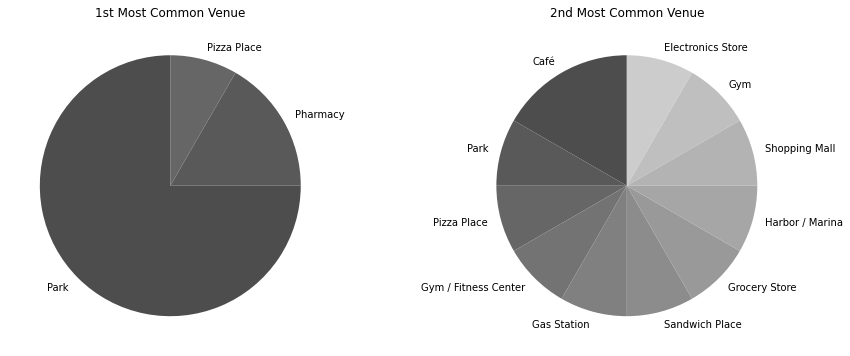

In [394]:
plot_insights(Cluster_1)

In [395]:
Cluster_1.set_index(['Borough','Neighborhood'])

1st Most Common Venue  \
Borough          Neighborhood                                                               
Etobicoke        Islington Avenue, Humber Valley Village                         Pharmacy   
East York        Parkview Hill, Woodbine Gardens                                 Pharmacy   
Etobicoke        West Deane Park, Princess Gardens, Martin Grove...                  Park   
Scarborough      Rouge Hill, Port Union, Highland Creek                              Park   
North York       Bathurst Manor, Wilson Heights, Downsview North                     Park   
                 Bayview Village                                                     Park   
                 Downsview                                                    Pizza Place   
                 Humber Summit                                                       Park   
Scarborough      Cliffside, Cliffcrest, Scarborough Village West                     Park   
                 Birch Cliff, Cliffside West                                         Park   
Downtown Toronto CN Tower, King and Spadina, Railway Lands, Harb...                  Park   
Etobicoke        New Toronto, Mimico South, Humber Bay Shores                        Park   

                                                                    2nd Most Common Venue  \
Borough          Neighborhood                                                               
Etobicoke        Islington Avenue, Humber Valley Village                    Shopping Mall   
East York        Parkview Hill, Woodbine Gardens                                     Park   
Etobicoke        West Deane Park, Princess Gardens, Martin Grove...        Sandwich Place   
Scarborough      Rouge Hill, Port Union, Highland Creek              Gym / Fitness Center   
North York       Bathurst Manor, Wilson Heights, Downsview North              Pizza Place   
                 Bayview Village                                              Gas Station   
                 Downsview                                                  Grocery Store   
                 Humber Summit                                          Electronics Store   
Scarborough      Cliffside, Cliffcrest, Scarborough Village West          Harbor / Marina   
                 Birch Cliff, Cliffside West                                          Gym   
Downtown Toronto CN Tower, King and Spadina, Railway Lands, Harb...                  Café   
Etobicoke        New Toronto, Mimico South, Humber Bay Shores                        Café   

                                                                    3rd Most Common Venue  \
Borough          Neighborhood                                                               
Etobicoke        Islington Avenue, Humber Valley Village                             Bank   
East York        Parkview Hill, Woodbine Gardens                              Pizza Place   
Etobicoke        West Deane Park, Princess Gardens, Martin Grove...  Gym / Fitness Center   
Scarborough      Rouge Hill, Port Union, Highland Creek                       Pizza Place   
North York       Bathurst Manor, Wilson Heights, Downsview North              Coffee Shop   
                 Bayview Village                                                     Bank   
                 Downsview                                                           Park   
                 Humber Summit                                                     Bakery   
Scarborough      Cliffside, Cliffcrest, Scarborough Village West              Pizza Place   
                 Birch Cliff, Cliffside West                                         Café   
Downtown Toronto CN Tower, King and Spadina, Railway Lands, Harb...                   Gym   
Etobicoke        New Toronto, Mimico South, Humber Bay Shores          Mexican Restaurant   

                                                                     4th Most Common Venue  \
Borough          Neighborhood                                    

## Cluster 2 (31 neighborhoods)
### The neighborhood with cafes, italian places and fast food options. It has a variety of venues.
* It's good option if you want to have more options for coffee and quick bites. it also has sport facilities. 
* Mostly situated outside of downtown area. 

In [396]:
Cluster_2 = df_top10_labeled.loc[df_top10_labeled['Cluster Labels']==1, :]
Cluster_2 = Cluster_2.drop(['Latitude', 'Longitude', 'Cluster Labels'],1)

In [397]:
Cluster_2.shape

(31, 12)

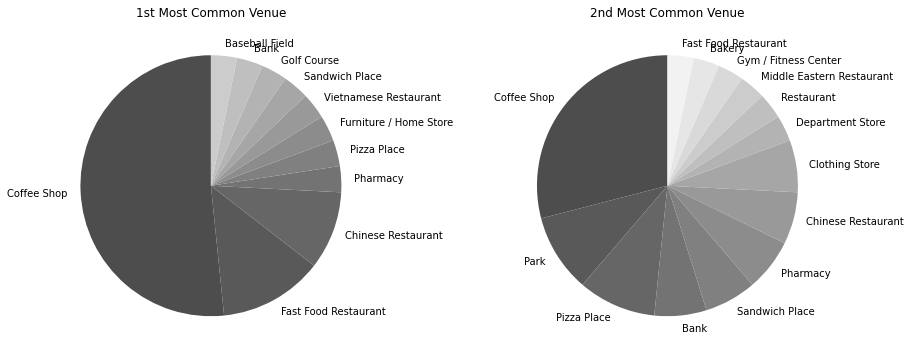

In [398]:
plot_insights(Cluster_2)

In [399]:
Cluster_2.set_index(['Borough','Neighborhood'])

1st Most Common Venue  \
Borough     Neighborhood                                                                 
North York  Parkwoods                                                         Pharmacy   
            Victoria Village                                               Coffee Shop   
            Glencairn                                                      Coffee Shop   
East York   Woodbine Heights                                               Coffee Shop   
Etobicoke   Eringate, Bloordale Gardens, Old Burnhamthorpe,...          Baseball Field   
Scarborough Guildwood, Morningside, West Hill                              Pizza Place   
            Woburn                                                         Coffee Shop   
            Cedarbrae                                                      Coffee Shop   
North York  Hillcrest Village                                              Coffee Shop   
Scarborough Scarborough Village                                         Sandwich Place   
North York  Fairview, Henry Farm, Oriole                                   Coffee Shop   
            Northwood Park, York University                                Coffee Shop   
Scarborough Kennedy Park, Ionview, East Birchmount Park                    Coffee Shop   
            Golden Mile, Clairlea, Oakridge                                Coffee Shop   
North York  York Mills, Silver Hills                                       Coffee Shop   
            North Park, Maple Leaf Park, Upwood Park              Fast Food Restaurant   
York        Del Ray, Mount Dennis, Keelsdale and Silverthorn    Furniture / Home Store   
North York  Humberlea, Emery                                               Golf Course   
York        Runnymede, The Junction North                                  Coffee Shop   
            Weston                                               Vietnamese Restaurant   
Scarborough Dorset Park, Wexford Heights, Scarborough Town ...    Fast Food Restaurant   
North York  York Mills West                                                Coffee Shop   
Etobicoke   Westmount                                                             Bank   
North York  Willowdale, Willowdale West                                    Coffee Shop   
Etobicoke   Kingsview Village, St. Phillips, Martin Grove G...             Coffee Shop   
Scarborough Agincourt                                               Chinese Restaurant   
            Clarks Corners, Tam O'Shanter, Sullivan               Fast Food Restaurant   
            Milliken, Agincourt North, Steeles East, L'Amor...      Chinese Restaurant   
Etobicoke   South Steeles, Silverstone, Humbergate, Jamesto...    Fast Food Restaurant   
Scarborough Steeles West, L'Amoreaux West                           Chinese Restaurant   
Etobicoke   Northwest, West Humber - Clairville                            Coffee Shop   

                                                                    2nd Most Common Venue  \
Borough     Neighborhood                                                                    
North York  Parkwoods                                                         Coffee Shop   
            Victoria Village                                    Middle Eastern Restaurant   
            Glencairn                                                Fast Food Restaurant   
East York   Woodbine Heights                                                         Park   
Etobicoke   Eringate, Bloordale Gardens, Old Burnhamthorpe,...                Coffee Shop   
Scarborough Guildwood, Morningside, West Hill                                        Bank   
            Woburn                                                               Pharmacy   
            Cedarbrae                                                      Clothing Store   
North York  Hillcrest Village                                          Chinese Restaurant   
Scarborough Scarborough Village                                        

## Cluster 3 (55 neighborhoods)
### The neighborhood with more cafes, multi national restaurants. It has a variety of venues.
* It's good option if you want to have more options for coffee or dine out.
* Many situated in downtown area. 

In [400]:
Cluster_3 = df_top10_labeled.loc[df_top10_labeled['Cluster Labels']==2, :]
Cluster_3 = Cluster_3.drop(['Latitude', 'Longitude', 'Cluster Labels'],1)

In [401]:
Cluster_3.shape

(55, 12)

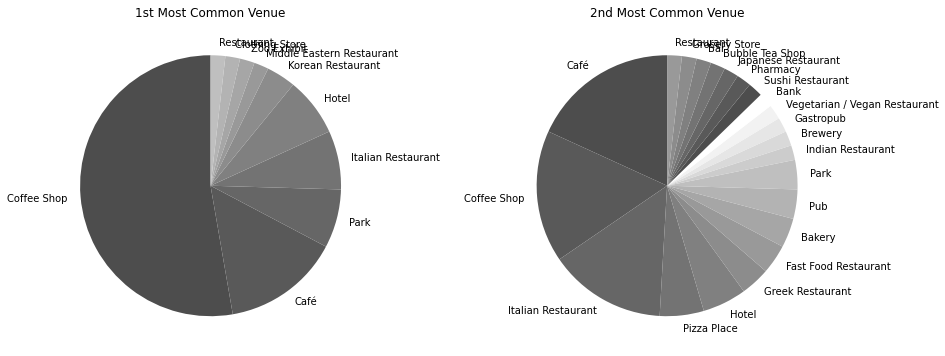

In [402]:
plot_insights(Cluster_3)

In [403]:
Cluster_3.set_index(['Borough','Neighborhood'])

1st Most Common Venue  \
Borough          Neighborhood                                                                    
Downtown Toronto Regent Park, Harbourfront                                         Coffee Shop   
North York       Lawrence Manor, Lawrence Heights                               Clothing Store   
Downtown Toronto Queen's Park, Ontario Provincial Government                       Coffee Shop   
Scarborough      Malvern, Rouge                                                    Zoo Exhibit   
North York       Don Mills                                                         Coffee Shop   
Downtown Toronto Garden District, Ryerson                                          Coffee Shop   
                 St. James Town                                                    Coffee Shop   
York             Humewood-Cedarvale                                                Coffee Shop   
East Toronto     The Beaches                                                       Coffee Shop   
Downtown Toronto Berczy Park                                                       Coffee Shop   
York             Caledonia-Fairbanks                                               Coffee Shop   
East York        Leaside                                                           Coffee Shop   
Downtown Toronto Central Bay Street                                                Coffee Shop   
                 Christie                                                                 Café   
East York        Thorncliffe Park                                                  Coffee Shop   
Downtown Toronto Richmond, Adelaide, King                                          Coffee Shop   
West Toronto     Dufferin, Dovercourt Village                                             Café   
East York        East Toronto, Broadview North (Old East York)                            Café   
Downtown Toronto Harbourfront East, Union Station, Toronto Islands                       Hotel   
West Toronto     Little Portugal, Trinity                                                 Café   
East Toronto     The Danforth West, Riverdale                                             Café   
Downtown Toronto Toronto Dominion Centre, Design Exchange                                Hotel   
West Toronto     Brockton, Parkdale Village, Exhibition Place                             Café   
East Toronto     India Bazaar, The Beaches West                                           Park   
Downtown Toronto Commerce Court, Victoria Hotel                                          Hotel   
North York       Willowdale, Newtonbrook                                     Korean Restaurant   
East Toronto     Studio District                                                   Coffee Shop   
North York       Bedford Park, Lawrence Manor East                          Italian Restaurant   
                 Willowdale, Willowdale East                                 Korean Restaurant   
Central Toronto  Lawrence Park                                                     Coffee Shop   
                 Roselawn                                                          Coffee Shop   
                 Davisville North                                           Italian Restaurant   
                 Forest Hill North &amp; West, Forest Hill Road ...                Coffee Shop   
West Toronto     High Park, The Junction South                                     Coffee Shop   
Scarborough      Wexford, Maryvale                                   Middle Eastern Restaurant   
Central Toronto  North Toronto West,  Lawrence Park                                Coffee Shop   
                 The Annex, North Midtown, Yorkville                               Coffee Shop   
West Toronto     Parkdale, Roncesvalles                                            Coffee Shop   
Mississauga      Canada Post Gateway Processing Centre                             Coffee Shop   
Central Toronto  Davisville                            

## Cluster 4 (1 neighborhood)
### The neighborhood with farm and National park.
* It's good option if you want to relax and prefer quiet place. 
* It's situated suburban area. 

In [404]:
Cluster_4 = df_top10_labeled.loc[df_top10_labeled['Cluster Labels']==3, :]
Cluster_4 = Cluster_4.drop(['Latitude', 'Longitude', 'Cluster Labels'],1)

In [405]:
Cluster_4.shape

(1, 12)

In [406]:
Cluster_4.set_index(['Borough','Neighborhood'])

,,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Borough,Neighborhood,,,,,,,,,,
Scarborough,Upper Rouge,National Park,Farm,Donut Shop,Fish Market,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop
